## project1：用房价预测案例掌握机器学习基础流程

我们来一步步拆解房价预测问题，就像解数学题一样，先理清思路再动手。以下是引导你思考的框架，每一步都可以先自己想想，再看后面的提示。


### **第一步：明确问题——这是一个什么类型的任务？**  
房价预测属于**监督学习**中的**回归问题**（因为目标值是连续的数值，比如房价多少钱）。  
**思考点**：  
- 回归问题和分类问题的核心区别是什么？（提示：输出值是连续还是离散）  
- 你需要用哪些指标衡量模型的好坏？（比如均方误差MSE、平均绝对误差MAE等，先想想它们的公式）  


### **第二步：数据理解——你的数据长什么样？**  
假设你有一批房屋数据，每个样本包含若干特征（如面积、房间数、楼层、地理位置等）和对应的房价（标签）。  
**思考点**：  
- 观察数据中的特征类型：哪些是数值型（如面积）？哪些是类别型（如地理位置的区域名称）？  
- 类别型特征能直接丢进模型吗？如果不能，该怎么处理？（提示：独热编码/标签编码）  
- 数据中有没有缺失值？如果有，该如何处理？（删除？填充？用什么值填充？）  
- 特征之间是否存在明显的相关性？比如面积大的房子是否房价更高？如何验证？（提示：画散点图、计算相关系数）  

- 让我们先引入数据看看（**数据来源于scikit_learn中加州房价数据**）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# 加载加州房价数据集（更贴近实际场景，样本量更大）
california_housing = fetch_california_housing()
X = california_housing.data
y = california_housing.target
feature_names = california_housing.feature_names

# 查看数据集信息
print("数据集描述：", california_housing.DESCR)
print("特征形状：", X.shape)  # (20640, 8)
print("目标值形状：", y.shape)  # (20640,)

数据集描述： .. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row

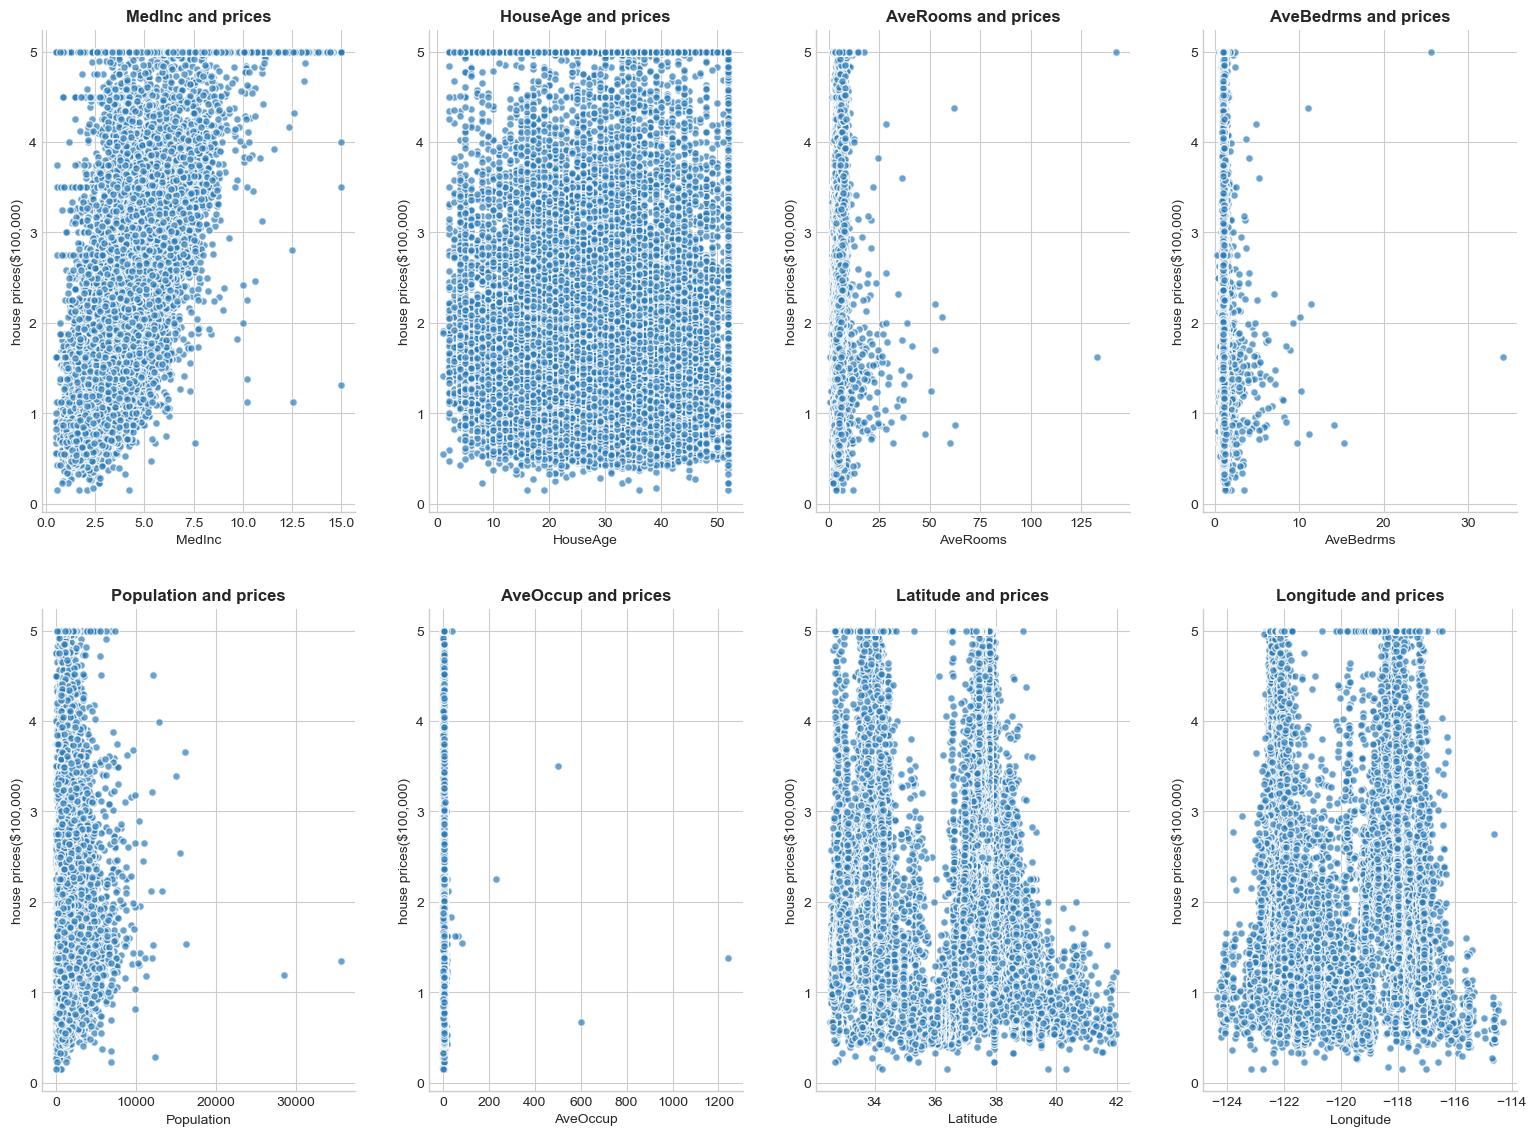

In [2]:
plt.style.use("seaborn-v0_8-whitegrid")  # 或用 sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

for i in range(X.shape[1]):
    plt.subplot(2, 4, i+1)
    plt.scatter(X[:, i], y, alpha=0.7, s=30, color="#2c7bb6", edgecolor="white")
    plt.title(f"{feature_names[i]} and prices", fontweight="bold", fontsize=12)
    plt.xlabel(feature_names[i], fontsize=10)
    plt.ylabel("house prices($100,000)", fontsize=10)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout(pad=3)

plt.show()

### **第三步：数据预处理——让数据“干净”且“适合模型”**  
这一步是建模的基础，直接影响模型效果。  
**思考点**：  
- 特征尺度差异大吗？比如面积是几千，房间数是个位数，是否需要做特征缩放？（提示：归一化/标准化，两者的区别是什么？）  
- 如何划分训练集和测试集？为什么不能用全部数据训练？测试集的比例怎么选？（比如8:2或7:3）  
- 是否需要做交叉验证？什么时候需要？（提示：当数据量小或想更可靠评估模型时）  


**mean normalization**

In [3]:
def mean_normalization(data):
    """
    对输入数据进行均值归一化
    :param data: 输入的一维或二维数组，形状为 (n_samples,) 或 (n_samples, n_features)
    :return: 均值归一化后的数据
    """
    mean_value = np.mean(data, axis=0)
    max_value = np.max(data, axis=0)
    min_value = np.min(data, axis=0)
    normalized_data = (data - mean_value) / (max_value - min_value)
    return normalized_data

**zero normalization**

In [4]:
def zero_normalization(data):
    """
    对输入数据进行零均值归一化（Z - score标准化）
    :param data: 输入的一维或二维数组，形状为 (n_samples,) 或 (n_samples, n_features)
    :return: Z - score标准化后的数据
    """
    mean_value = np.mean(data, axis=0)
    std_value = np.std(data, axis=0)
    # 防止除数为0的情况
    std_value[std_value == 0] = 1e-8
    normalized_data = (data - mean_value) / std_value
    return normalized_data

接下来看看归一化的效果：

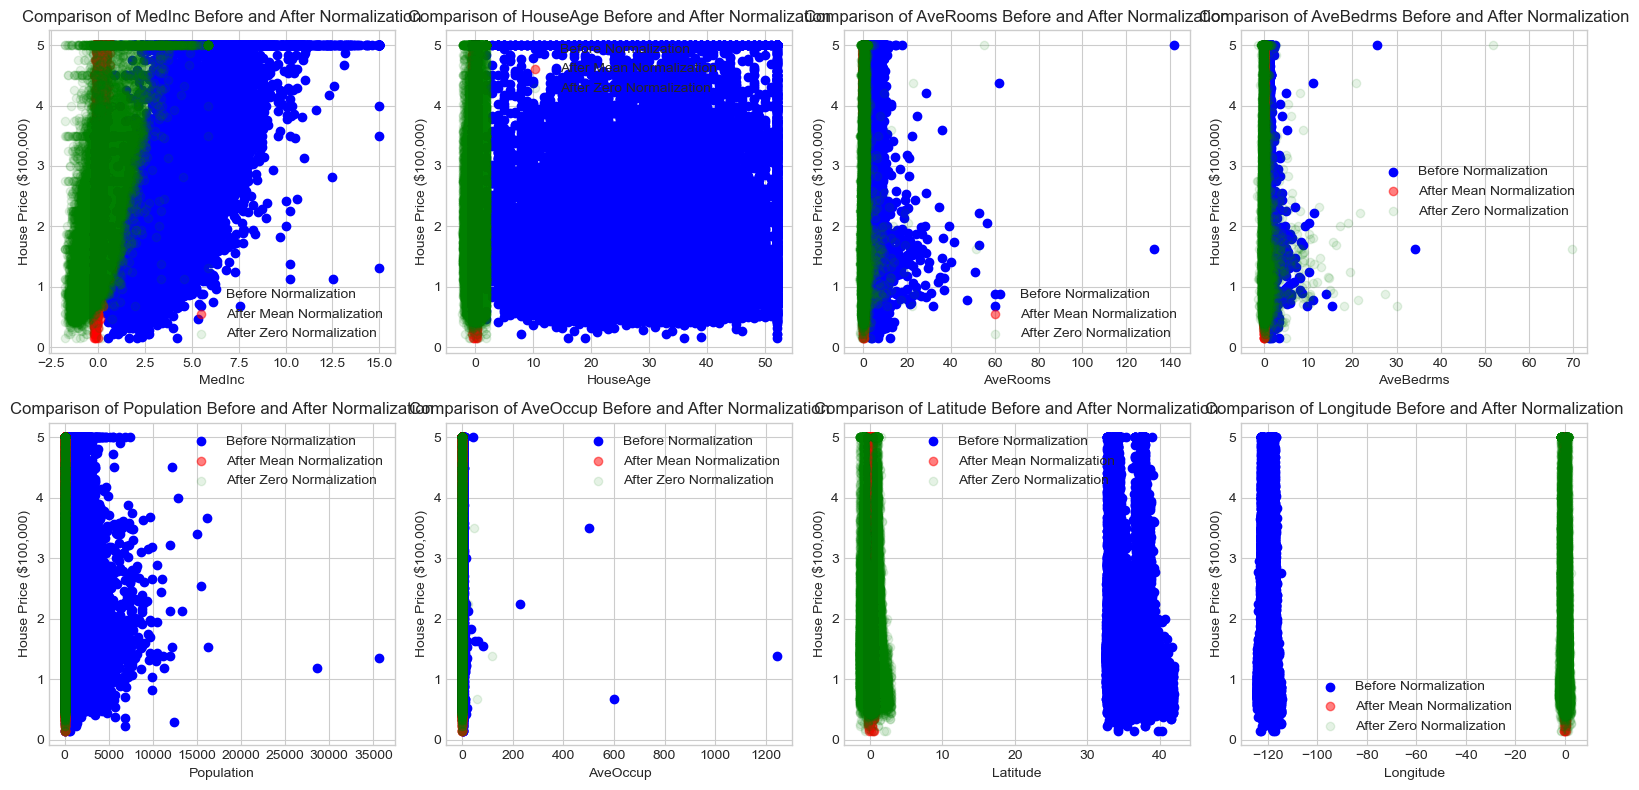

In [5]:
# 绘制所有特征归一化前后的对比散点图
n_features = X.shape[1]
fig, axes = plt.subplots(nrows=2, ncols=n_features // 2, figsize=(16, 8))

for i in range(n_features):
    selected_feature = X[:, i]
    # 归一化处理
    mean_norm_feature = mean_normalization(selected_feature.reshape(-1, 1)).flatten()
    zero_norm_feature = zero_normalization(selected_feature.reshape(-1, 1)).flatten()

    row = i // (n_features // 2)
    col = i % (n_features // 2)
    ax = axes[row, col]

    # 绘制归一化前的散点图
    ax.scatter(selected_feature, y, c='b', label='Before Normalization', alpha=1.0)
    # 绘制均值归一化后的散点图
    ax.scatter(mean_norm_feature, y, c='r', label='After Mean Normalization', alpha=0.5)
    # 绘制零均值归一化后的散点图
    ax.scatter(zero_norm_feature, y, c='g', label='After Zero Normalization', alpha=0.1)

    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('House Price ($100,000)')
    ax.set_title(f'Comparison of {feature_names[i]} Before and After Normalization')
    ax.legend()

plt.tight_layout()
plt.show()

### **第四步：选择模型——从简单到复杂尝试**  
回归问题有很多经典模型，建议从简单模型开始，再逐步尝试复杂模型。  
**思考点**：  
- 最基础的模型是什么？（提示：线性回归，假设房价和特征是线性关系）  
- 线性回归的数学表达式怎么写？参数如何求解？（提示：梯度下降）  
- 如果线性模型效果不好，可能是什么原因？（提示：特征和房价可能是非线性关系，比如面积的平方影响房价）  
- 非线性模型可以尝试哪些？（提示：多项式回归、决策树、随机森林、梯度提升树等，先想想它们的原理） 

#### 我们就不尝试自己构造函数来拟合了，要学会使用scikit_learn

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
# 梯度下降实现
def gradient_descent(X, y, learning_rate=0.01, max_iterations=1000):
    """
    批量梯度下降实现线性回归
    :param X: 特征矩阵 (n_samples, n_features)
    :param y: 目标值 (n_samples,)
    :param learning_rate: 学习率
    :param max_iterations: 最大迭代次数
    :return: 训练好的参数和每次迭代的MSE
    """
    m, n = X.shape
    theta = np.zeros(n)  # 初始化参数
    mse_history = []  # 记录每次迭代的MSE
    
    for iteration in range(max_iterations):
        # 计算预测值
        y_pred = np.dot(X, theta)
        # 计算误差
        error = y_pred - y
        # 计算MSE
        mse = np.mean(error ** 2)
        mse_history.append(mse)
        # 计算梯度
        gradient = np.dot(X.T, error) / m
        # 更新参数
        theta = theta - learning_rate * gradient
        
        # 打印进度（每100次迭代）
       # if (iteration + 1) % 100 == 0:
        #    print(f"迭代 {iteration+1}/{max_iterations}, MSE: {mse:.4f}")
    
    return theta, mse_history

### **第五步：模型训练——调参和优化**  
模型训练不是“跑一遍代码”就结束，需要不断调整参数。  
**思考点**：  
- 如何判断模型是否过拟合？（提示：训练集误差低，测试集误差高）  
- 过拟合时该怎么处理？（提示：减少特征数量、增加数据量、正则化等，正则化的公式是什么？）  
- 超参数如何调整？比如随机森林的树的数量、最大深度等，用什么方法调参？（提示：网格搜索/随机搜索）  

绘制学习率曲线来看看构造的是否合理

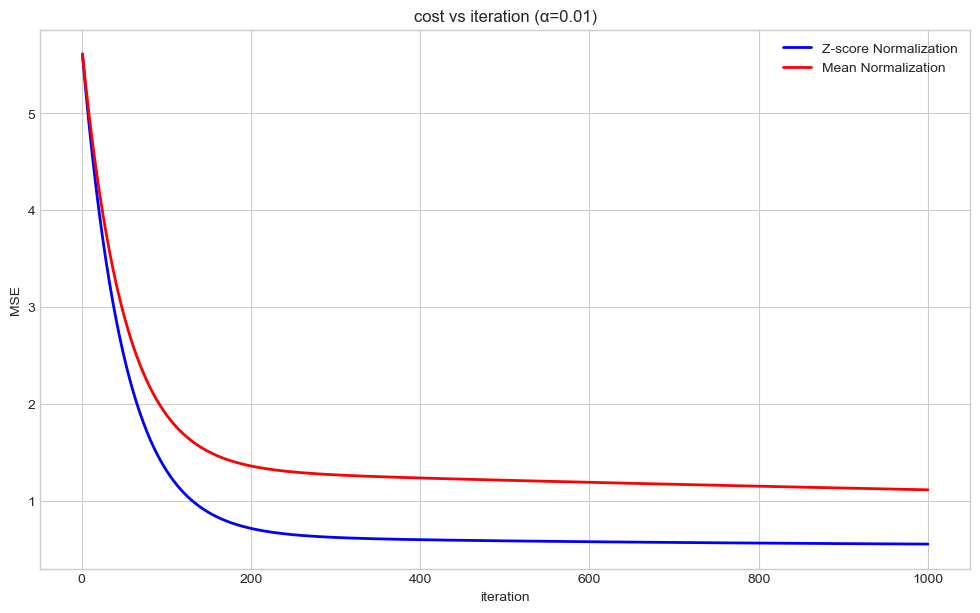

In [8]:
# 准备梯度下降所需的数据
# 1. 使用Z-score标准化
X_zero_normalized = zero_normalization(X)
X_zero_b = np.c_[np.ones((X_zero_normalized.shape[0], 1)), X_zero_normalized]  # 添加偏置列

# 2. 使用均值归一化
X_mean_normalized = mean_normalization(X)
X_mean_b = np.c_[np.ones((X_mean_normalized.shape[0], 1)), X_mean_normalized]  # 添加偏置列

# 设置相同的学习率和迭代次数
learning_rate = 0.01
max_iterations = 1000

# 执行梯度下降（Z-score标准化）
theta_zero, mse_history_zero = gradient_descent(X_zero_b, y, learning_rate, max_iterations)

# 执行梯度下降（均值归一化）
theta_mean, mse_history_mean = gradient_descent(X_mean_b, y, learning_rate, max_iterations)

# 绘制对比学习曲线
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(mse_history_zero) + 1), mse_history_zero, 'b-', linewidth=2, label='Z-score Normalization')
plt.plot(range(1, len(mse_history_mean) + 1), mse_history_mean, 'r-', linewidth=2, label='Mean Normalization')
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.title(f'cost vs iteration (α={learning_rate})')
plt.grid(True)
plt.legend()
plt.show()


In [9]:
### **第六步：模型评估——用数据验证效果**  
训练完模型后，必须用测试集评估真实表现。  
**思考点**：  
- 用你选的评估指标（如MSE）计算模型在测试集上的误差，这个误差是否可以接受？  
- 如果误差太大，可能哪里出了问题？（数据预处理？模型选择？特征不够？）  
- 是否需要尝试组合模型（集成学习）？比如将多个模型的结果加权平均，为什么可能提升效果？

SyntaxError: invalid character '，' (U+FF0C) (2763316227.py, line 2)

### **现在请你回答自己几个问题**  
1. 如果你的数据中“地理位置”是“市中心”“郊区”这样的类别，你会怎么处理这个特征？  
2. 假设线性回归的训练误差很小，但测试误差很大，你会优先尝试哪种调优方法？  
3. 为什么在特征缩放时，标准化需要计算均值和标准差，而归一化不需要？  

带着这些问题去查资料或动手实践，会理解得更深刻哦！  